<h1 align="center">K-means Clustering</h1>

In [3]:
# Slow
apps = parse_apps('kmeans')
b2s = bytes2samples(apps)

# Predicting the number of tasks per stage

In [104]:
_rows = {'samples': [], 'stage': [], 'tasks': []}
for app in apps:
    input_size = get_input_size(app)
    samples = b2s[input_size]
    for stage_id, stage in enumerate(app.stages):
        tasks = sum(1 for t in stage.tasks if not t.failed)
        _rows['samples'].append(samples)
        _rows['stage'].append(stage_id)
        _rows['tasks'].append(tasks)

# Tasks per stage data frame
df_tps = pd.DataFrame(_rows)
del _rows
df_tps.sample(3)

,samples,stage,tasks
7567,128,1,5
12070,32,6,5
3928,2048,2,5


In [211]:
_group = df_tps.groupby(['samples', 'stage'])        # group by samples and stage
for nr_of_tasks in _group['tasks'].unique().values:  # different tasks quantities
    # the number of tasks is the same for a given stage and number of samples
    assert len(nr_of_tasks) == 1                     

df_tps_uniq = _group['tasks'].unique().apply(lambda x: x[0])
del _group
df_tps_uniq = df_tps_uniq.unstack(-2)
df_tps_uniq#.loc[[0, 14]]

samples,32,64,128,256,512,1024,2048,4096,8192,16384
stage,,,,,,,,,,
0,5,5,5,5,5,5,5,10,25,100
1,5,5,5,5,5,5,5,10,25,100
...,...,...,...,...,...,...,...,...,...,...
24,2,2,2,2,2,2,2,2,2,2
25,5,5,5,5,5,5,5,10,25,100


In [212]:
# Profiling phase data frame
df_prof = df_tps_uniq.stack().reset_index(name='tasks')
df_prof = df_prof[df_prof.samples < 8192]

from sklearn import linear_model, metrics
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

# Stage 0 prediction
def log_model(degree):
    method = linear_model.LinearRegression(fit_intercept=False)
    model = Pipeline([('poly', PolynomialFeatures(degree=degree)), ('method', method)])
    df0 = df_prof[df_prof.stage == 0].drop('stage', axis=1).apply(np.log2)
    model.fit(df0['samples'].reshape(-1, 1), df0['tasks'])
    prediction = model.predict(np.arange(5, 15).reshape(-1,1))
    return np.power(2, prediction).round().astype(int)

print('Stage 0:')
for degree in range(1, 5):
    print('- Degree {:d}: {}'.format(degree, log_model(degree)))

Stage 0:
- Degree 1: [4 5 5 5 6 6 6 7 7 7]
- Degree 2: [ 5  5  5  5  5  5  6  8 11 15]
- Degree 3: [ 5  5  5  5  5  5  6  9 20 63]
- Degree 4: [  5   5   5   5   5   5   5  10  44 783]


# Two models

## Cache effect

In [ ]:
# Test with visual detection (on profiling fase?! Maybe it is better to automate.
# But it is difficult. First, try on real data and check if it is feasible)

In [474]:
def get_total_time_df(apps):
    columns = ['input', 'workers', 'seconds']
    table = {col: [] for col in columns}
    for app in apps:
        bytes_read = get_bytes_read(app)
        table['input'].append(bytes_read)
        table['workers'].append(app.slaves)
        table['seconds'].append(app.duration)

    df = pd.DataFrame(table, columns=columns)
    df.seconds /= 1000
    df.input = df.input.apply(lambda b: b2s[b])
    return df

df = get_total_time_df(apps)

# Outliers
outliers = calc_outliers(df, 'seconds', ['input', 'workers'], 3)
print('{:d} outliers from {:d} measurements.'.format(sum(outliers), len(outliers)), end=' ')
print('There are 10 executions for each input/worker combination:')
print(df[outliers].groupby(columns[:-1]).size())

5 outliers from 740 measurements. There are 10 executions for each input/worker combination:
input  workers
32     2          1
       3          2
       8          1
16384  128        1
dtype: int64


## Regression on all workers

Degree and mean squared error for 8 million samples:
1 2.98782385421
2 0.246459309933
3 10.517441474
4 7.82530633526
5 8.976812905

Degree and mean squared error for 16 million samples:
1 4.0625214342
2 0.551091453553
3 12.5063832259
4 11.9884714806
5 7.33405870713


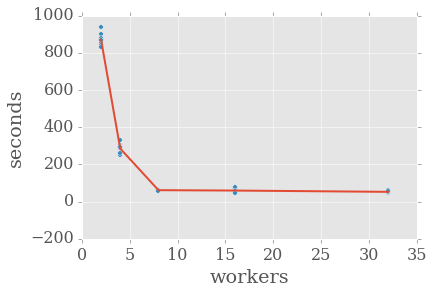

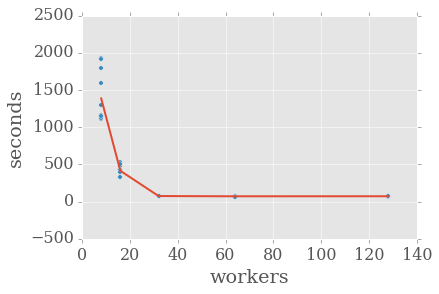

In [558]:
# Some useful column names
features = ['input', 'workers']
truth = 'seconds'
model_obj = 'model_pickle'

def log_model(df, degree):
    method = linear_model.LinearRegression(fit_intercept=False)
    model = Pipeline([('poly', PolynomialFeatures(degree=degree)), ('method', method)])
    df_log = df.apply(np.log2)
    features_log = df_log['workers'].reshape(-1, 1)
    target_log = df_log['seconds']
    return -cross_validation.cross_val_score(model, features_log, target_log, scoring='mean_squared_error').mean()

df3 = df[~outliers & (df.input == 8192)].drop('input', axis=1)
print('Degree and mean squared error for 8 million samples:')
for degree in range(1, 6):
    print(degree, log_model(df3, degree))
    
df30 = df[~outliers & (df.input == 16384)].drop('input', axis=1)
print('\nDegree and mean squared error for 16 million samples:')
for degree in range(1, 6):
    print(degree, log_model(df30, degree))
    
model3 = Pipeline([('poly', PolynomialFeatures(degree=degree)),
                   ('method', linear_model.LinearRegression(fit_intercept=False))])
features = np.log2(df3['workers']).reshape(-1, 1)
model3.fit(features, np.log2(df3['seconds']))
predictions = np.power(2, model3.predict(features))
ax = df3.plot.scatter('workers', 'seconds')
ax.plot(df3.workers, predictions)

model30 = Pipeline([('poly', PolynomialFeatures(degree=degree)),
                   ('method', linear_model.LinearRegression(fit_intercept=False))])
features = np.log2(df30['workers']).reshape(-1, 1)
model30.fit(features, np.log2(df30['seconds']))
predictions = np.power(2, model30.predict(features))
ax = df30.plot.scatter('workers', 'seconds')
ax.plot(df30.workers, predictions)

## Using two models

In [526]:
df3 = df[~outliers & (df.input == 8192) & df.workers.isin([2, 4, 8])].drop('input', axis=1)
print('Degree and relative error mean for 8 million samples:')
for degree in range(1, 6):
    print(degree, log_model(df3, degree))
    
df30 = df[~outliers & (df.input == 16384)].drop('input', axis=1)
print('\nDegree and relative error mean for 16 million samples:')
for degree in range(1, 6):
    print(degree, log_model(df30, degree))

Degree and relative error mean for 8 million samples:
1 44.68961119267741
2 43.77099980649537
3 43.77099980649537
4 43.77099980649537
5 43.77099980649537

Degree and relative error mean for 16 million samples:
1 35.4107927636614
2 43.9215850111658
3 43.0630622073278
4 42.80907365337671
5 42.80907365337671


### Detection

In [559]:
set(t.locality for a in apps for s in a.stages for t in s.tasks)

{'ANY', 'PROCESS_LOCAL'}

In [560]:
# TODO Show ANY is slower

In [561]:
columns=['input', 'workers', 'stage', 'non_local']
_df_data = {col: [] for col in columns}
for app in apps:
    input_size = b2s[get_input_size(app)]
    for stage_id, stage in enumerate(app.stages):
        _df_data['input'].append(input_size)
        _df_data['workers'].append(app.slaves)
        _df_data['stage'].append(stage_id)
        _df_data['non_local'].append(sum(t.locality != 'PROCESS_LOCAL' for t in stage.tasks))

# Non-local tasks data frame
df_nl = pd.DataFrame(_df_data, columns=columns)
del _df_data
df_nl[(df_nl.non_local > 0) & (df_nl.input > 8000)].drop_duplicates()

,input,workers,stage,non_local
8320,8192,2,0,25
8321,8192,2,1,9
...,...,...,...,...
10400,16384,64,0,100
10660,16384,128,0,100


In [649]:
def log_model(degree, stage_id):
    method = linear_model.LinearRegression(fit_intercept=False)
    model = Pipeline([('poly', PolynomialFeatures(degree=degree)), ('method', method)])
    df_prof = df_nl[(df_nl.input < 8192) & (df_nl.non_local > 0)]
    print(df_prof)
    df_st = df_prof[df_prof.stage == stage_id].drop('stage', axis=1).apply(np.log2)
    features = df_st.drop('non_local', axis=1)
    target = df_st['non_local']
    model.fit(features, target)
    return model

stage_id = 0
df_target = df_nl[(df_nl.input >= 8192) & (df_nl.stage == stage_id)].drop('stage', axis=1)
truth = df_target['non_local']
features = df_target.drop('non_local', axis=1).apply(np.log2)
model = log_model(3, stage_id)
prediction = np.power(2, model.predict(features))
print(np.unique(prediction))
print(np.abs((truth - prediction)/truth).mean())

# Unique values of non-local tasks per size and stage
#df_nlu = df_nl.groupby(columns).size()

#print('Different numbers of slow tasks')
#for n_samples in df_nlu.index.levels[0]:
#    for workers in df_nlu.index.levels[1]:
#        for stage in df_nlu.index.levels[2]:
#            slow_tasks = df_nlu[n_samples][workers][stage]
#            if len(slow_tasks) > 1:
#                info = []
#                for quantity, count in zip(slow_tasks.index, slow_tasks.values):
#                    info.append('{:d} ({:d})'.format(quantity, count))
#                print('{:02d}k samples, {:02d} workers, stage {:02d}: {}'.format(n_samples, workers, stage, ', '.join(info)))

       input  workers  stage  non_local
0         32        1      0          5
26        32        1      0          5
...      ...      ...    ...        ...
19188   4096        8      0         10
19214   4096        8      0         10

[680 rows x 4 columns]
[ 20.          20.          20.          20.          20.          63.49604208
  63.49604208  63.49604208  63.49604208  63.49604208]
0.28251978960585533


## Required Code

In [418]:
# Common for all experiments

## Python settings
from glob import glob
import sys
if not 'spark_log_stats' in sys.path:
    sys.path.append('spark_log_stats')
import pandas as pd
import numpy as np
## Show graph in this notebook instead of opening a window
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from sparklogstats import LogParser

## Make graphs more readable
matplotlib.style.use('ggplot')
matplotlib.rcParams.update({'font.size': 16,
                            'font.family': 'serif',
                            'lines.linewidth': 2})
pd.options.display.max_rows = 4
pd.options.display.precision = 2


def parse_apps(folder):
    parser = LogParser()
    apps = []
    for log in sorted(glob('data/hibench/{}/*'.format(folder))):
        app = parser.parse_file(log)
        app.slaves = len(app.slaves)
        apps.append(app)
    return apps

# Conversion from bytes read from input files to number of samples (thousands)
# The number of samples was manually entered for input generation
# Return a dict conversor where key is bytes read and value is the number of samples in thousands
def get_bytes2samples_conv(apps):
    def _get_bytes_read(app):
        tasks = app.stages[0].tasks
        return sum(t.metrics.bytes_read for t in tasks if not t.failed)

    b2s = {}
    k_samples = 32
    for size in sorted(set(_get_bytes_read(a) for a in apps)):
        b2s[size] = k_samples
        k_samples *= 2

    return b2s

def get_input_size(app):
    tasks = app.stages[0].tasks
    return sum(t.metrics.bytes_read for t in tasks if not t.failed)

In [423]:
# Outliers
def calc_outliers(df, col, group_by, m):
    group = df.groupby(group_by)
    lower = group[col].transform(lambda x: x.quantile(q=.25) - m*(x.quantile(q=.75)-x.quantile(q=.25)))
    upper = group[col].transform(lambda x: x.quantile(q=.75) + m*(x.quantile(q=.75)-x.quantile(q=.25)))
    return (df[col] > upper) | (df[col] < lower)

In [511]:
# Regression

# For each profiling configuration subset (worker numbers, input sizes)
## for each linear regression method
### for each degree
#### build a model

import pickle
from itertools import chain, combinations
from sklearn import linear_model, metrics, cross_validation
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
import pyprind

class Regressor:
    def __init__(self, df, truth_col, features, max_degree, apply_log):
        self._df = df.apply(np.log2) if apply_log else df
        self._truth = truth_col
        self._features = features
        self._degrees = list(range(1, max_degree + 1))
        self._apply_log = apply_log
        self.methods = [
           linear_model.LinearRegression(fit_intercept=False),
#           linear_model.Lasso(),
#           linear_model.ElasticNet(),
#           linear_model.RidgeCV()
        ]

    # exclude void subset
    @staticmethod
    def powerset(iterable):
        s = list(iterable)
        return chain.from_iterable(combinations(s, r) for r in range(1, len(s)+1))
    
    def _init_progress_bar(self):
        n = 0
        df = self._df
        uniq_inputs = df.input.unique()
        for inputs in Regressor.powerset(uniq_inputs):
            uniq_workers = df[df.input.isin(inputs)].workers.unique()
            n += sum(1 for _ in Regressor.powerset(uniq_workers))
        return pyprind.ProgBar(n, title='Regression', monitor=True)
        

    def make_regressions(self):
        bar = self._init_progress_bar()
        regressions = []
        df = self._df
        uniq_inputs = df.input.unique()
        for inputs in Regressor.powerset(uniq_inputs):
            uniq_workers = df[df.input.isin(inputs)].workers.unique()
            for workers in Regressor.powerset(uniq_workers):
                df_reg = df[df.workers.isin(workers) & df.input.isin(inputs)]
                for method in self.methods:
                    for degree in self._degrees:
                        reg = self._add_regression(df_reg, degree, method, workers, inputs)
                        regressions.append(reg)
                bar.update()
        print(bar)
        return pd.DataFrame(regressions)
    
        
    def _add_regression(self, df, degree, method, workers, inputs):
        model = self._build_model(df, degree, method)
        return self._get_regression_info(model, degree, workers, inputs)
    
    def _build_model(self, df, degree, method):
        model = Pipeline([('poly', PolynomialFeatures(degree=degree)), ('method', method)])
        model.fit(df[self._features], df[self._truth])
        return model
    
    def _from_log(self, value):
        return np.power(2, value) if self._apply_log else value
        
    def _get_regression_info(self, model, degree, workers, inputs):
        inputs = tuple(np.round(inputs).astype(int))
        return {
            'method': str(model.named_steps['method'].__class__).split('.')[-1].split("'")[0],
            'degree': degree,
            'workers': self._from_log(workers),
            'inputs': self._from_log(inputs),
            'model_pickle': pickle.dumps(model)
        }

    
class RelativeError:
    def __init__(self, features, models, truth, is_log):
        self._features = features
        self._models = models
        self._truth = truth
        self._is_log = is_log
        self._bar = pyprind.ProgBar(models.size, title='Relative error', monitor=True)
    
    def get_errors(self):
        errors = [self._calc_from_model(m) for m in self._models]
        print(self._bar)
        return errors
            
    def _calc_from_model(self, model_pickle):
        model = pickle.loads(model_pickle)
        predictions = model.predict(self._features)
        if self._is_log:
            predictions = np.power(2, predictions)
        return self._calc(self._truth, predictions)
    
    def _calc(self, y_true, y_prediction):
        self._bar.update()
        return (np.abs(y_true - y_prediction)/y_true).mean()